In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score




In [104]:
df = pd.read_csv("TrainData1.txt", sep="\t", header=None)
df_test = pd.read_csv("TestData1.txt", sep="\t", header=None)


In [105]:
df_test.shape

(53, 3312)

In [75]:
df.shape

(150, 3312)

In [76]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311
0,3.824254,1.923762,1.918450,2.352067e+00,3.117298,3.051735,3.307977,3.430222e+00,3.586667,3.605218,...,1.836830,1.855640,1.142389,2.054345,2.808224,1.782186,2.665703,2.468214,2.478581,2.308842
1,3.904190,2.309524,2.152930,1.000000e+99,3.532368,3.524866,3.677791,3.636671e+00,3.696868,3.716764,...,1.951532,1.442323,1.000000,2.127914,2.979658,1.961089,2.519027,2.054383,2.689903,2.090928
2,3.750908,1.161068,1.017033,2.347993e+00,3.381889,3.393096,3.509134,3.512466e+00,3.622203,3.603050,...,1.000000,1.584105,1.000000,1.945321,3.257004,1.965061,2.536066,1.449324,2.605230,1.368659
3,3.809383,1.912355,1.856940,2.498944e+00,3.289406,3.371232,3.541995,1.000000e+99,3.473179,3.628930,...,1.869965,1.481658,1.000000,2.155032,3.270371,1.928473,2.618074,2.154013,2.530046,2.185514
4,3.893561,2.094192,1.881271,2.785707e+00,3.344339,3.274417,3.485872,3.516527e+00,3.642358,3.688235,...,1.480725,1.510545,1.000000,2.094192,3.246666,1.824516,2.562317,1.942256,2.598517,1.764624


In [106]:
df.replace(1.000000e+99, np.nan, inplace=True)
df_test.replace(1.000000e+99, np.nan, inplace=True)
y = pd.read_csv("TrainLabel1.txt", sep=" ", header=None)
y= y.values.ravel()
X = df

In [78]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    """
    Drops features that are highly correlated with others.
    threshold: absolute correlation above this is considered "too high"
    """
    def __init__(self, threshold=0.9):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Convert to array + remember feature names if DataFrame
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = np.array(X.columns)
            X_values = X.values
        else:
            self.feature_names_in_ = np.arange(X.shape[1])
            X_values = np.asarray(X)

        corr = np.corrcoef(X_values, rowvar=False)
        n_features = corr.shape[0]

        to_drop = set()
        # Only look at upper triangle (i < j)
        for i in range(n_features):
            for j in range(i + 1, n_features):
                if abs(corr[i, j]) > self.threshold and j not in to_drop:
                    # drop the later feature (you could change rule)
                    to_drop.add(j)

        self.to_keep_idx_ = [i for i in range(n_features) if i not in to_drop]
        self.to_keep_mask_ = np.zeros(n_features, dtype=bool)
        self.to_keep_mask_[self.to_keep_idx_] = True

        # Optional: store names that are kept
        self.features_kept_ = self.feature_names_in_[self.to_keep_mask_]

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.features_kept_]
        else:
            X_values = np.asarray(X)
            return X_values[:, self.to_keep_idx_]

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_log = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("feature_sel", SelectFromModel(
        LogisticRegression(max_iter=5000)
    )),
    ("clf", LogisticRegression(max_iter=1000))
])

# 3. Train
pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_log.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))




Test accuracy: 1.0
Confusion Matrix:
[[22  0  0  0]
 [ 0  3  0  0]
 [ 0  0  2  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [100]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)

scores = cross_val_score(
    pipe_log,  # or pipe_log / best_model
    X, y,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Mean F1:", scores.mean())
print("Std F1:", scores.std())
print("All scores:", scores)

Mean F1: 0.9542534289030179
Std F1: 0.02951369717129511
All scores: [0.95742943 0.91441441 0.97013699 0.97813699 0.96       0.92834286
 0.97013699 0.91631918 1.         1.         0.93342222 0.93041096
 0.95742943 0.88533333 1.         0.97902588 0.97902588 0.91257143
 0.97813699 0.92989148 0.97870841 0.97813699 0.92866032 0.93898239
 0.9342     0.95387387 0.9300935  1.         0.95090909 0.95387387]


In [107]:
# Run prediction:
preds = pipe_log.predict(df_test)
probs = pipe_log.predict_proba(df_test)

print("Predictions:", preds)

Predictions: [2 1 1 1 1 2 1 1 3 2 3 1 1 1 5 1 1 1 1 1 1 4 3 3 4 1 5 4 1 3 1 1 4 1 3 1 1
 4 3 5 3 1 4 1 1 1 1 3 1 1 1 5 1]


In [109]:
with open("CuervoTrazonaClassification1.txt", "w") as f:
    for p in preds:
        f.write(str(p) + "\n")

In [97]:
pipe_simple = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

# 3. Train
pipe_simple.fit(X_train, y_train)
y_pred = pipe_simple.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_simple.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Test accuracy: 1.0
Confusion Matrix:
[[22  0  0  0]
 [ 0  3  0  0]
 [ 0  0  2  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [95]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)

scores = cross_val_score(
    pipe_simple,  # or pipe_log / best_model
    X, y,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Mean F1:", scores.mean())
print("Std F1:", scores.std())
print("All scores:", scores)


Mean F1: 0.9718023080840098
Std F1: 0.022780862747130353
All scores: [0.97902588 0.93898239 0.97013699 0.97813699 0.98076825 0.97870841
 1.         0.93707763 1.         1.         0.97870841 0.96
 1.         0.93898239 1.         0.97902588 0.97902588 0.93357746
 0.97813699 0.94148223 0.97870841 0.97813699 0.92866032 0.96342857
 0.9342     1.         0.95968254 1.         0.98076825 0.97870841]


In [80]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_rf = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca",PCA(5)),
    ("clf", RandomForestClassifier(random_state=42))
])

# 3. Train
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_rf.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))


Test accuracy: 0.9666666666666667
Confusion Matrix:
[[22  0  0  0]
 [ 1  2  0  0]
 [ 0  0  2  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3

    accuracy                           0.97        30
   macro avg       0.99      0.92      0.94        30
weighted avg       0.97      0.97      0.96        30



In [81]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_knn = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("model", KNeighborsClassifier(n_neighbors=3))
])

# 3. Train
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_knn.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.9666666666666667
Confusion Matrix:
[[22  0  0  0]
 [ 1  2  0  0]
 [ 0  0  2  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3

    accuracy                           0.97        30
   macro avg       0.99      0.92      0.94        30
weighted avg       0.97      0.97      0.96        30



In [82]:
from sklearn.neural_network import MLPClassifier

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_mlp = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("model", MLPClassifier(
    hidden_layer_sizes=(100, 100),  # two hidden layers
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
))
])

# 3. Train
pipe_mlp.fit(X_train, y_train)
y_pred = pipe_mlp.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_mlp.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.9666666666666667
Confusion Matrix:
[[22  0  0  0]
 [ 1  2  0  0]
 [ 0  0  2  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3

    accuracy                           0.97        30
   macro avg       0.99      0.92      0.94        30
weighted avg       0.97      0.97      0.96        30



In [83]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_svm = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("svm", SVC(kernel="rbf", C=10.0, gamma="scale"))
])

# 3. Train
pipe_svm.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_svm.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))


Test accuracy: 0.9666666666666667
Confusion Matrix:
[[22  0  0  0]
 [ 0  3  0  0]
 [ 1  0  1  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       1.00      1.00      1.00         3
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         3

    accuracy                           0.97        30
   macro avg       0.99      0.88      0.91        30
weighted avg       0.97      0.97      0.96        30



In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.1, 0.01],
    "svm__kernel": ["rbf"]
}

grid = GridSearchCV(pipe_svm, param_grid, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

c:\Users\17063\OneDrive\Machine Learning 4850\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

In [85]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

# 2. Pipeline
pipe_nb = Pipeline([
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("var_thresh", VarianceThreshold(threshold=0.01)), 
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
    ("pca", PCA(5)),
    ("model", GaussianNB())
])

# 3. Train
pipe_nb.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)

# 4. Evaluate
print("Test accuracy:", pipe_nb.score(X_test, y_test))
# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))


Test accuracy: 0.9666666666666667
Confusion Matrix:
[[22  0  0  0]
 [ 0  3  0  0]
 [ 1  0  1  0]
 [ 0  0  0  3]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       1.00      1.00      1.00         3
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         3

    accuracy                           0.97        30
   macro avg       0.99      0.88      0.91        30
weighted avg       0.97      0.97      0.96        30



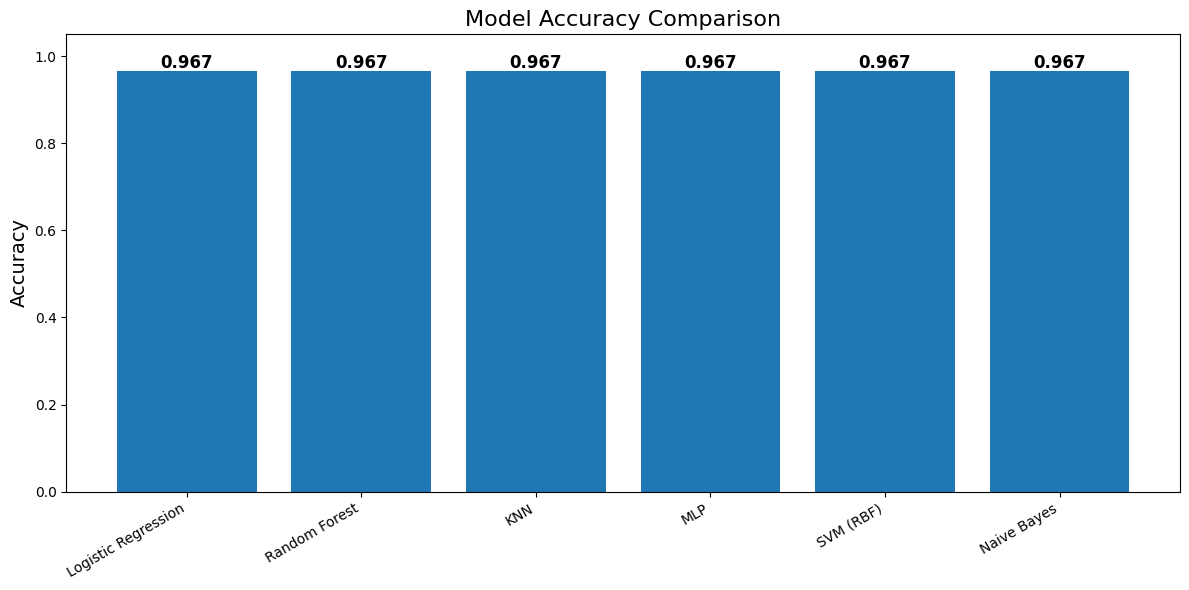

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dictionary of your fitted models from the notebook
models = {
    "Logistic Regression": pipe_log,
    "Random Forest": pipe_rf,
    "KNN": pipe_knn,
    "MLP": pipe_mlp,
    "SVM (RBF)": pipe_svm,
    "Naive Bayes": pipe_nb,
}


# --------------------------------------------
#  CALCULATE ACCURACY FOR EACH MODEL
# --------------------------------------------
accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# --------------------------------------------
#  PLOT BAR CHART
# --------------------------------------------
plt.figure(figsize=(12,6))

bars = plt.bar(accuracies.keys(), accuracies.values())

# Add accuracy text above bars
for bar, value in zip(bars, accuracies.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.005,
        f"{value:.3f}",
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

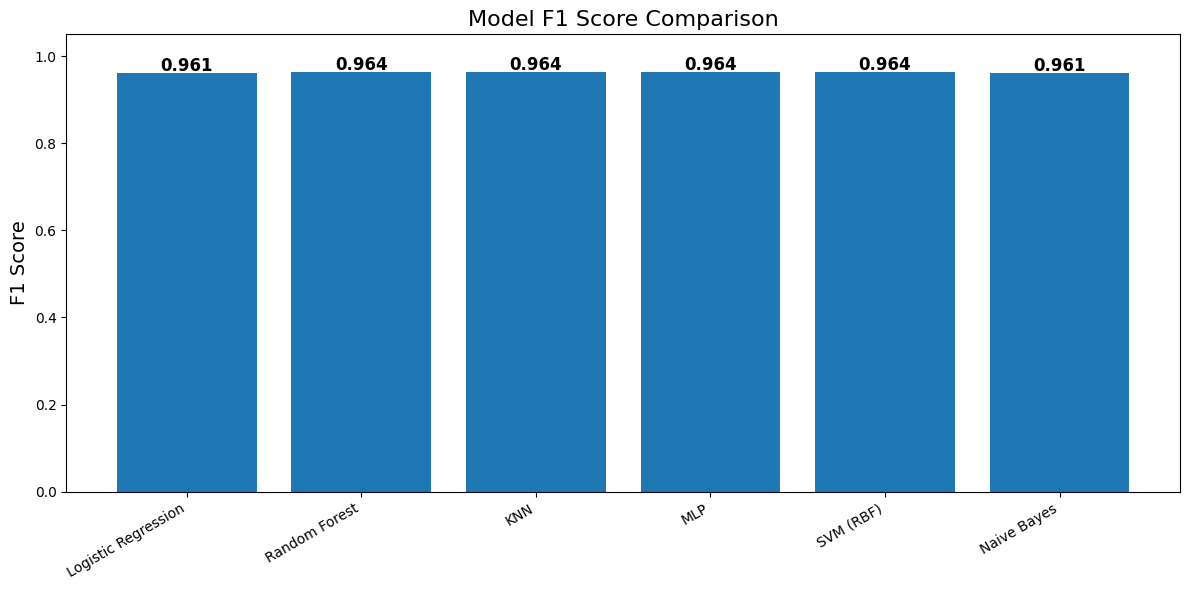

In [87]:
from sklearn.metrics import f1_score

# --------------------------------------------
#  CALCULATE F1 SCORE FOR EACH MODEL
# --------------------------------------------
f1_scores = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    f1_scores[name] = f1_score(y_test, y_pred, average='weighted')

# --------------------------------------------
#  PLOT BAR CHART
# --------------------------------------------
plt.figure(figsize=(12,6))

bars = plt.bar(f1_scores.keys(), f1_scores.values())

# Add F1 score text above bars
for bar, value in zip(bars, f1_scores.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.005,
        f"{value:.3f}",
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Model F1 Score Comparison", fontsize=16)
plt.ylabel("F1 Score", fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()


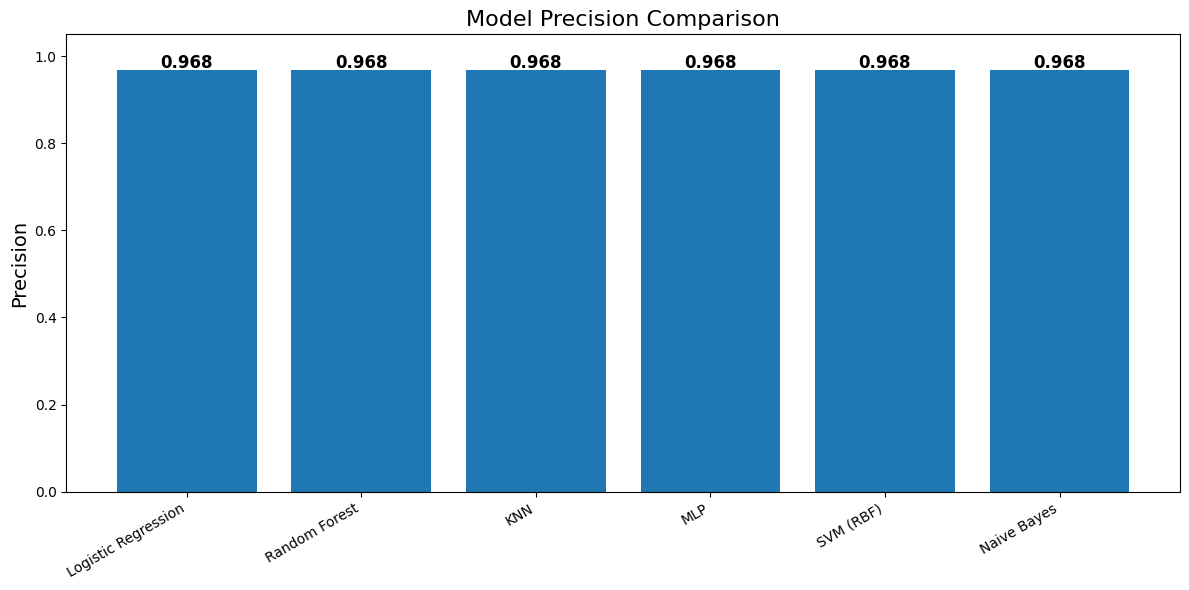

In [88]:
from sklearn.metrics import precision_score

# --------------------------------------------
#  CALCULATE PRECISION FOR EACH MODEL
# --------------------------------------------
precisions = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    precisions[name] = precision_score(y_test, y_pred, average='weighted')

# --------------------------------------------
#  PLOT BAR CHART
# --------------------------------------------
plt.figure(figsize=(12,6))

bars = plt.bar(precisions.keys(), precisions.values())

# Add precision text above bars
for bar, value in zip(bars, precisions.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.005,
        f"{value:.3f}",
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Model Precision Comparison", fontsize=16)
plt.ylabel("Precision", fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()


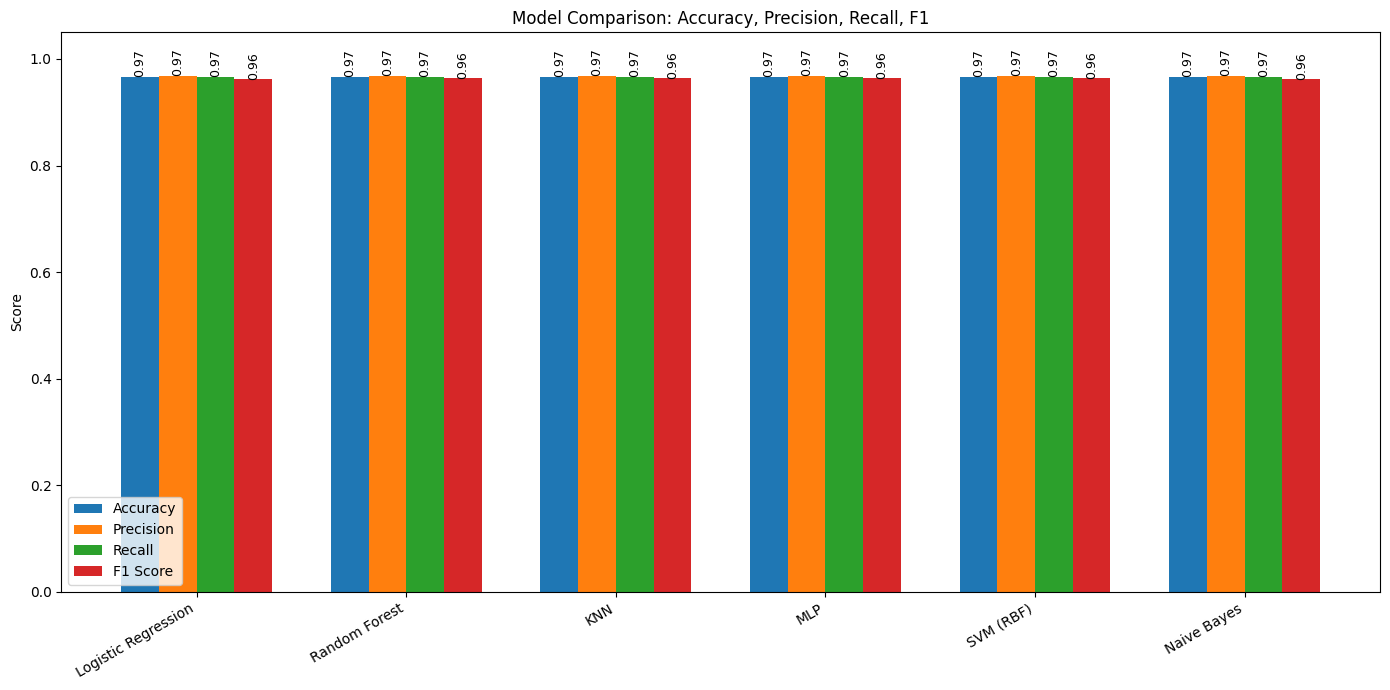

In [89]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------------------
#  CALCULATE METRICS FOR EACH MODEL
# ------------------------------------------------
metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1 Score": {}
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    metrics["Accuracy"][name]  = accuracy_score(y_test, y_pred)
    metrics["Precision"][name] = precision_score(y_test, y_pred, average='weighted')
    metrics["Recall"][name]    = recall_score(y_test, y_pred, average='weighted')
    metrics["F1 Score"][name]  = f1_score(y_test, y_pred, average='weighted')

# ------------------------------------------------
#  GROUPED BAR CHART
# ------------------------------------------------
plt.figure(figsize=(14, 7))

model_names = list(models.keys())
x = np.arange(len(model_names))  # positions for each model

metric_names = list(metrics.keys())  # ["Accuracy", "Precision", "Recall", "F1 Score"]
num_metrics = len(metric_names)

bar_width = 0.18
offsets = np.linspace(-bar_width * (num_metrics-1) / 2,
                      bar_width * (num_metrics-1) / 2,
                      num_metrics)

for i, metric_name in enumerate(metric_names):
    values = [metrics[metric_name][m] for m in model_names]
    bars = plt.bar(x + offsets[i], values, width=bar_width, label=metric_name)
    
    # Optional: add small text labels above bars
    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            v + 0.005,
            f"{v:.2f}",
            ha='center',
            fontsize=9,
            rotation=90
        )

plt.xticks(x, model_names, rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, Precision, Recall, F1")
plt.legend()
plt.tight_layout()
plt.show()


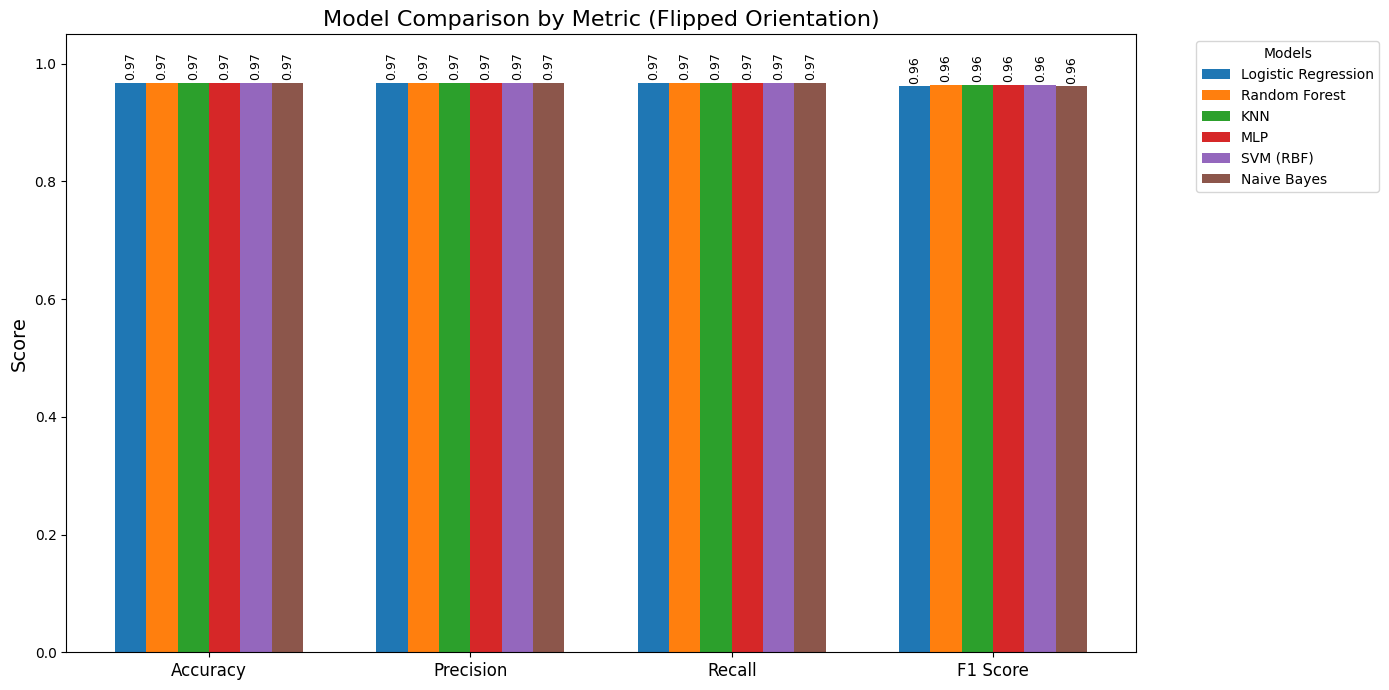

In [90]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------------------
#  CALCULATE METRICS FOR EACH MODEL
# ------------------------------------------------
metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1 Score": {}
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    metrics["Accuracy"][name]  = accuracy_score(y_test, y_pred)
    metrics["Precision"][name] = precision_score(y_test, y_pred, average='weighted')
    metrics["Recall"][name]    = recall_score(y_test, y_pred, average='weighted')
    metrics["F1 Score"][name]  = f1_score(y_test, y_pred, average='weighted')

# ------------------------------------------------
#   FLIPPED GROUPED BAR PLOT
# ------------------------------------------------
metric_names = list(metrics.keys())           # ["Accuracy", "Precision", "Recall", "F1 Score"]
model_names = list(models.keys())             # your 6 model names
num_models = len(model_names)

x = np.arange(len(metric_names))              # metric positions
bar_width = 0.12
offsets = np.linspace(
    -bar_width * (num_models - 1) / 2,
    bar_width * (num_models - 1) / 2,
    num_models
)

plt.figure(figsize=(14, 7))

for i, model_name in enumerate(model_names):
    values = [metrics[m][model_name] for m in metric_names]
    bars = plt.bar(x + offsets[i], values, width=bar_width, label=model_name)

    # Add values on top of bars
    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            v + 0.01,
            f"{v:.2f}",
            ha="center",
            fontsize=9,
            rotation=90
        )

plt.xticks(x, metric_names, fontsize=12)
plt.ylabel("Score", fontsize=14)
plt.title("Model Comparison by Metric (Flipped Orientation)", fontsize=16)
plt.ylim(0, 1.05)
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



In [92]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# ------------------------------------------------
#  DEFINE SCORING METRICS
# ------------------------------------------------
scoring = {
    "accuracy":  make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average='weighted'),
    "recall":    make_scorer(recall_score, average='weighted'),
    "f1":        make_scorer(f1_score, average='weighted')
}

# ------------------------------------------------
#  3-FOLD CROSS-VALIDATION FOR EACH MODEL
# ------------------------------------------------
cv_summary = []

for name, model in models.items():
    cv_results = cross_validate(
        model,
        X, y,           # use full dataset
        cv=3,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    cv_summary.append({
        "Model": name,
        "Accuracy (mean)":  cv_results["test_accuracy"].mean(),
        "Accuracy (std)":   cv_results["test_accuracy"].std(),
        "Precision (mean)": cv_results["test_precision"].mean(),
        "Precision (std)":  cv_results["test_precision"].std(),
        "Recall (mean)":    cv_results["test_recall"].mean(),
        "Recall (std)":     cv_results["test_recall"].std(),
        "F1 (mean)":        cv_results["test_f1"].mean(),
        "F1 (std)":         cv_results["test_f1"].std(),
    })

cv_df = pd.DataFrame(cv_summary)
cv_df = cv_df.sort_values(by="F1 (mean)", ascending=False)

print(cv_df)


                 Model  Accuracy (mean)  Accuracy (std)  Precision (mean)  \
0  Logistic Regression         0.940000        0.028284          0.937500   
2                  KNN         0.940000        0.016330          0.920857   
3                  MLP         0.933333        0.009428          0.921010   
1        Random Forest         0.933333        0.009428          0.914618   
5          Naive Bayes         0.926667        0.009428          0.912746   
4            SVM (RBF)         0.920000        0.000000          0.915222   

   Precision (std)  Recall (mean)  Recall (std)  F1 (mean)  F1 (std)  
0         0.034798       0.940000      0.028284   0.934429  0.030048  
2         0.019804       0.940000      0.016330   0.929545  0.018232  
3         0.002973       0.933333      0.009428   0.925405  0.006095  
1         0.011728       0.933333      0.009428   0.921453  0.009842  
5         0.006007       0.926667      0.009428   0.916741  0.010307  
4         0.014027       0.920000 